# Quantum Neural Network-based correlation for frictional pressure drop of non-azeotropic mixtures during cryogenic forced boiling

This work proposes a Quantum neural network-based methodology to estimate frictional pressure drop during boiling in mini-channels of non-azeotropic mixtures including nitrogen, methane, ethane, and propane. The methodology can assist in thermal analysis or design of heat exchangers used in cryogenic applications. The proposed model architecture includes the local quality, roughness, mass flux, and Reynolds number as inputs and frictional pressure drop as outputs.
It will compare with one paper where my colleagues and I use the same data to create an ANN-based correlation for pressure drop estimation in microchannels [1].

[1] Barroso-Maldonado, J. M., Montañez-Barrera, J. A., Belman-Flores, J. M., and Aceves, S. M. (2019). ANN-based correlation for frictional pressure drop of non-azeotropic mixtures during cryogenic forced boiling. Applied Thermal Engineering, 149(August 2018), 492-501. https://doi.org/10.1016/j.applthermaleng.2018.12.082

### Experimental Data
The data of this project was obtained from Barraza et. al [2]. The input variables were choose based on the input used for the correlations which are the local quality, roughness, mass flux, and Reynolds number. The following tables show the conditions for each experiment.
<img src="./Images/T2.png" width="600">
<img src="./Images/T3.png" width="300">
<img src="./Images/T1.png" width="600">

[2] R.Barraza,G.Nellis,S.Klein,D.Reindl,Measuredandpredictedfrictionalpressure drop for boiling zeotropic mixed refrigerants in horizontal tubes, Int. J. Heat Mass Transf. 98 (2016) 285–298, https://doi.org/10.1016/j.ijheatmasstransfer.2016.03.010.

In [1]:
import numpy as np
import pennylane as qml
from tqdm import tqdm

In [2]:
trainData = np.load("./Data/trainData.npy")
testData = np.load("./Data/testData.npy")
data_set = np.concatenate((trainData,testData))
minD = np.min(data_set, axis=0)
maxD = np.max(data_set, axis=0)

normalized_data = (trainData - minD)/ (maxD - minD)

np.random.shuffle(normalized_data)

normalized_input = normalized_data[:,:4]
normalized_output = normalized_data[:,4]

normalized_test = (testData - minD)/ (maxD - minD)
normalized_test_i = normalized_test[:,:4]
normalized_test_o = normalized_test[:,4]

### QNN Architecture

After trying with different configurations for the QNN, the architecture that best fit the experimental data was one that used strongly entangling layers of size (3,4,3) and the input parameters before each of these layers. 

In [3]:
WIRES = 4
LAYERS = 3

def layer(params, x):
    for n, i in enumerate(x):          
        qml.RX(np.pi*i, wires=n)
    qml.templates.StronglyEntanglingLayers(params[:3,:,:], wires=range(WIRES))
def QNN_circuit(params, x):
    for i in range(LAYERS):
        layer(params[i*3:(i+1)*3],x)
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

### Training
For the training, I used mini-batches and my cost function is just the difference between the squared value of my output and the target output. The optimizer with better performance was the AdamOptimizer.

In [4]:
def to_real(data_norm,minD,maxD):
    return data_norm *(maxD-minD) + minD
def iterate_minibatches(inputs, targets, batch_size):
    """
    A generator for batches of the input data

    Args:
        inputs (array[float]): input data
        targets (array[float]): targets

    Returns:
        inputs (array[float]): one batch of input data of length `batch_size`
        targets (array[float]): one batch of targets of length `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

def correlation_training(X_train, Y_train, Params=None):
    """Develop and train a Quantum neural network to create a correlation for
    frictional pressure drop of non-azeotropic mixtures during cryogenic forced boiling.


    Args:
        X_train (np.ndarray): An array of floats of size (3929, 4) to be used as training data.
        Y_train (np.ndarray): An array of size (3929,) which is the frictional pressure
        drop normalized.
        Params (list): list of the parameters from a old optimization (to continue a training)
    Returns:
        params: (list len=epochs)Params of the circuit which produces the desired output
        Cost:(list len=epochs) Cost function for the different epochs
    """
    # Device used for training
    dev = qml.device("default.qubit", wires=WIRES)

    # Instantiate the QNode
    circuit = qml.QNode(QNN_circuit, dev)

    def cost_f(params, x, y):
        suma = 0
        n = len(x)
        for i in range(n):
            y_c = (circuit(params, x[i]) + 1) / 2
            suma += (y_c - y[i]) ** 2
        return suma

    # Train using Adam optimizer and evaluate the classifier
    learning_rate = 0.01
    epochs = 1
    batch_size = 75
    
    opt = qml.optimize.AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)
    
    # In case I want to continue with a prior training, I can load the history of Params
    if not isinstance(Params,list):
        params = np.random.random((3*LAYERS, WIRES, 3))
        Params = []
    else:
        params = Params[-1]
        
    Cost = [0] # To control where to stop the training 
    stop = 0 # Counter of times that the error is not reduce by a define quantity
    q_stop = 0.1 #Quantity to increase the stop, after three times the error is not reduce by more than this quantity
                # the training stops.
    
    for it in range(epochs):
        cost_sum = 0
        for Xbatch, ybatch in tqdm(iterate_minibatches(X_train, Y_train, batch_size=batch_size)):
            params, cost = opt.step_and_cost(lambda v: cost_f(v, Xbatch, ybatch), params)
            cost_sum += cost
        Params.append(params)
        Cost.append(cost_sum)
        print("Cost: ",cost_sum)
        if Cost[-2] - Cost[-1] < q_stop:
            stop += 1
        if stop > 2:
            break
        if it % 5 == 0: # Show the progress of the training with the test cases not used during training 
            Y_test = []
            for i in normalized_test_i:
                Y_test.append((circuit(params,i) + 1)/2)
            Y_test = np.array(Y_test)
            error_test = 100*np.sum(np.abs(to_real(Y_test,minD[-1],maxD[-1]) - 
                                           to_real(normalized_test_o,minD[-1],
                                                   maxD[-1]))/to_real(normalized_test_o,
                                                minD[-1],maxD[-1]))/len(Y_test)

            print("Error test: ", error_test)
        
    return Params, Cost

In [5]:
params, cost = correlation_training(normalized_input, normalized_output)

52it [07:06,  8.20s/it]


Cost:  315.42599356680574
Error test:  196.86086143163743


## Results
Below, I show the results for the different experiments. Even though I work with many different architectures, neither of them was good enough to get close to the performance of the ANN. The minimum error I got was for experiment K with mre = 6.8% and a similar error for the other experiments in Table 1 (with exception of experiment F).
The parameters used in this model were 3*3*4*3 = 108 parameters. With the ANN in paper [1], we used 11 neurons which means 44Weights + 11Bias  = 55 parameters. 

In [6]:
params = np.load("./Data/5_params.npy")# Trained values saved

In [7]:
dev = qml.device("default.qubit", wires=WIRES)
circuit = qml.QNode(QNN_circuit, dev)
prediction = {}

Data = {}
j = 1
last = 0
for i in range(1,len(trainData)-1):
    if trainData[i,0] - trainData[i+1,0] > 0.5:
        Data[j] = trainData[last:i+1,:]
        last = i+1
        j += 1
        
for i in range(1,19):
    data = Data[i]
    normalized = (data - minD) / (maxD - minD)
    prediction[i] = [data[:,0],[]]
    for x in normalized:
        prediction[i][1].append(((circuit(params[-1], x[:4]) + 1)/2)*(maxD[-1] - minD[-1]) + minD[-1]) 
    prediction[i][1] = np.array(prediction[i][1])

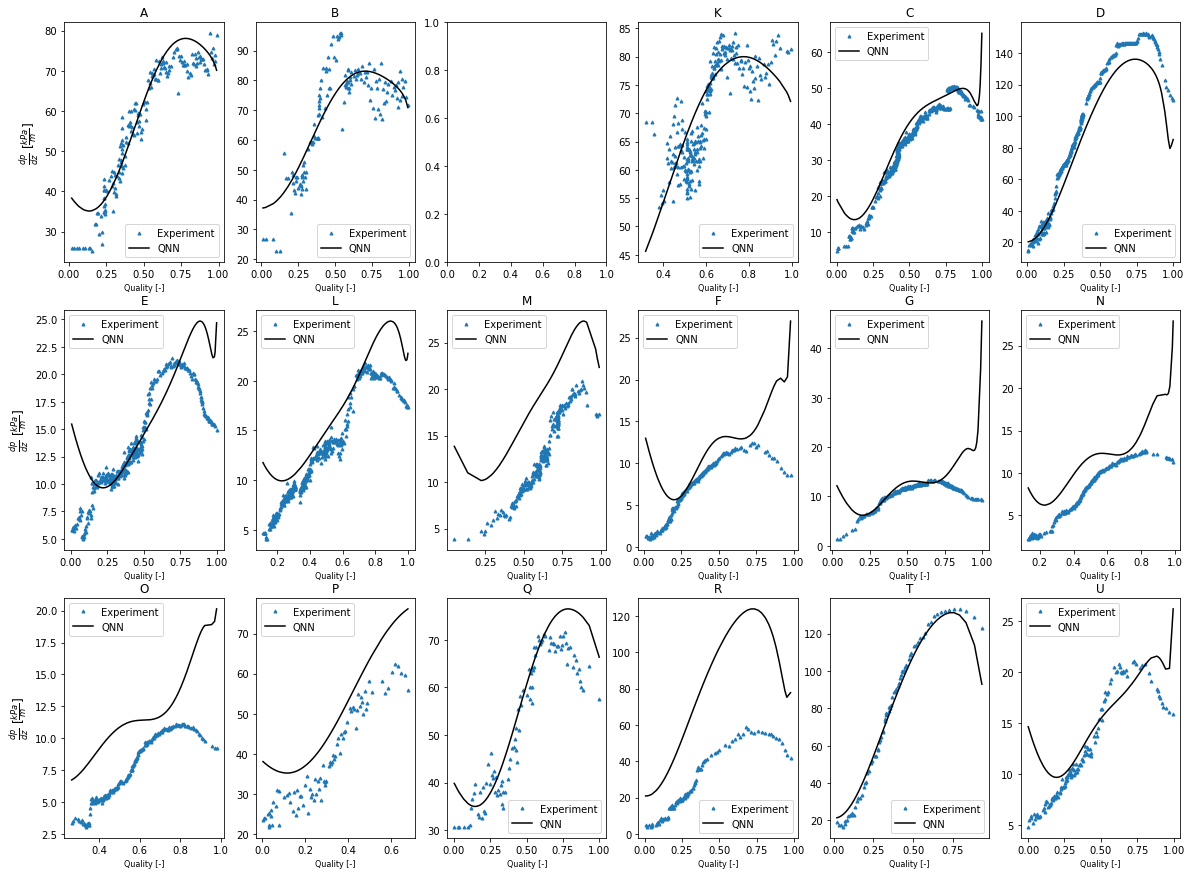

In [8]:
import matplotlib.pyplot as plt
folder = './Data/data_paper/'
fig, ax = plt.subplots(3,6, figsize = (20,15))
eN = ["A","B","J","K","C","D","E","L","M","F","G","N","O","P","Q","R","T","U"]
mre = []
for n, i in enumerate(range(1,19)):
    mre.append(100*(np.sum(abs(Data[i][:,-1] - prediction[i][1])/Data[i][:,-1])/len(Data[i][:,-1])))
    if not i == 3:
        ax[n//6, n%6].plot(Data[i][:,0],Data[i][:,-1],'^',label='Experiment',markersize = 3)
        ax[n//6, n%6].plot(prediction[i][0],prediction[i][1],label = 'QNN',color='black')
        ax[n//6, n%6].legend()
        if not n%6:
            ax[n//6, n%6].set_ylabel(r'$\frac{dp}{dz} \ [\frac{kPa}{m}]$',fontsize=12)
        ax[n//6, n%6].set_xlabel('Quality [-]',fontsize=8)
        ax[n//6, n%6].set_title(eN[n])
fig.savefig("./Images/Experiments.png")

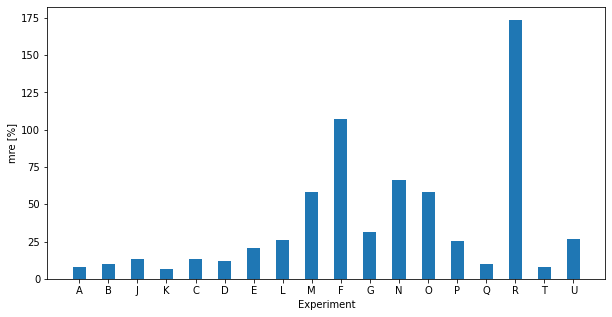

In [9]:
x = np.arange(len(eN))  # the label locations
width = 0.45  # the width of the bars

fig, ax = plt.subplots(figsize = (10,5))
rects1 = ax.bar(x, mre, width)
ax.set_xticks(x)
ax.set_xticklabels(eN)
ax.set_ylabel("mre [%]")
ax.set_xlabel("Experiment")
fig.savefig("./Images/mre.png")

In [10]:
print(f"The mre of the whole set of experiments is: {np.mean(mre)}")

The mre of the whole set of experiments is: 37.466885653516265


## Conclusions
The proposed model uses a set of experimental parameters as input variables: local quality (0–1), surface roughness (0.4–2.6 mm), mass flux (139–242 kgm−2 s−1), and Reynolds number (197–50,740). Based on mre for different architectures we chosse the QNN model. This model uses 3 StronglyEntanglingLayers and in between these layers RX rotation to encode the inputs. Using the mean relative error, it is demonstrated that the proposed QNN-based model does not give the expected result with a mean relative error mre = 37.5%. If compared with the best available correlations produce mean relative errors mre = 23.9% (Sun and Mishima), mre = 24.1% (Awad and Muzychka), mre = 25.3%, (Cicchitti et al.), and the ANN in [1] has mre = 8.3%.

I have two times more parameters in my QNN than those we used in the ANN [1]. Then, I do not think the problem is in the number of parameters used. Therefore, I have to change the architecture of the QNN and the way I encode the input data to get a better fit for the experimental results. 